In [117]:
import json
import os
import cv2
import mediapipe as mp
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from mediapipe.tasks import python
import time

In [118]:
# mp_hands = mp.solutions.hands
# hands = mp_hands.Hands()
# mp_drawing = mp.solutions.drawing_utils
# mediapipe stuff
BaseOptions = mp.tasks.BaseOptions
HandLandmarker = mp.tasks.vision.HandLandmarker
HandLandmarkerOptions = mp.tasks.vision.HandLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

In [119]:
options = HandLandmarkerOptions(
    base_options=BaseOptions(model_asset_path='./hand_landmarker.task', delegate=python.BaseOptions.Delegate.GPU),
    running_mode=VisionRunningMode.VIDEO, 
    min_hand_detection_confidence=0.0,
    num_hands=1)

In [120]:
path_to_data = Path("./dataset5/")

In [125]:
annotations = []
# with mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5) as hands:
with HandLandmarker.create_from_options(options) as landmarker:
    for fpath in tqdm(path_to_data.iterdir(), total=len(list(path_to_data.iterdir()))):
        if not fpath.is_dir():
            continue
        for letter_path in tqdm(fpath.iterdir(), total=len(list(fpath.iterdir()))):
            # print(letter_path.name)
            category = ord(letter_path.name.lower()) - 96
            # print(letter_path.name, category)
            for image_path in sorted(letter_path.iterdir()):
                if "depth" in image_path.name:
                    continue
                    
                # Read the image
                image = cv2.imread(str(image_path))
                if image is None:
                    print(f"Error reading image: {image_path}")
                    continue

                # Convert to RGB for Mediapipe
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image_rgb)
                # plt.imshow(image_rgb)

                # Process the image and detect hands
                # results = hands.process(image_rgb)
                results = landmarker.detect_for_video(mp_image, timestamp_ms=int(time.time() * 1000))
                
                height, width = image_rgb.shape[:2]

                # Extract hand keypoints
                keypoints = []
                hand_landmarks_list = results.hand_landmarks
                handedness_list = results.handedness
                if hand_landmarks_list:
                    for hand_landmarks, handedness in zip(hand_landmarks_list, handedness_list):
                        hand_label = handedness[0].category_name
                        score = handedness[0].score
                        # Right is actually left for ego
                        if hand_label == "Right":
                            keypoints.extend([[h.x, h.y, h.z] for h in hand_landmarks])
                        else:
                            keypoints.extend([[1-h.x, h.y, h.z] for h in hand_landmarks])
                    keypoints = np.array(keypoints)
                    row = [str(image_path), category]
                    row.extend(keypoints.flatten())
                    annotations.append(row)
                # else:
                    # plt.imshow(image_rgb)
                    # plt.show()
                    # break
                # plt.scatter(keypoints[:, 0]*width, keypoints[:, 1]*height)
                            

                # flipped_horizontally = cv2.flip(image_rgb, 1)
                # results = hands.process(flipped_horizontally)
                
                # plt.imshow(flipped_horizontally)
                # plt.scatter((1-keypoints[:, 0])*width, keypoints[:, 1]*height)

I0000 00:00:1732773421.487434    4470 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1732773421.511253   10018 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 530.30.02), renderer: NVIDIA TITAN V/PCIe/SSE2


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

In [126]:
import pandas as pd

In [127]:
score

0.9965165853500366

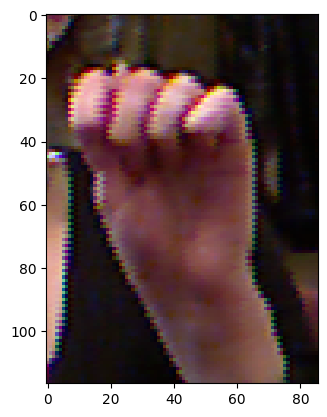

In [128]:
plt.imshow(image_rgb)

In [129]:
df = pd.DataFrame(annotations)

In [130]:
df.shape

(65303, 65)

In [131]:
# save df as a csv
df.to_csv(path_to_data / "mp_annotations.csv", index=False)

In [132]:
image_rgb.shape

(117, 86, 3)

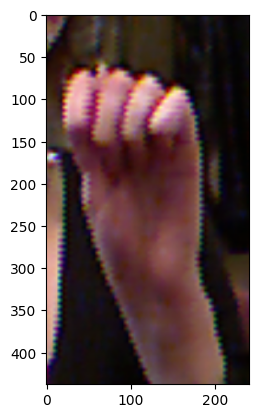

In [133]:
plt.imshow(cv2.resize(image_rgb, (240, 438)))

## Merge Datasets

In [15]:
import numpy as np
import pandas as pd
import json


In [16]:
train = json.load(open("data/_train.json", 'r'))
val = json.load(open("data/_val.json", 'r'))
test = json.load(open("data/_test.json", 'r'))


In [19]:
len(val['annotations'])
len(test['annotations'])

72

In [10]:
shuffled_df = data.sample(frac=1, random_state=42).reset_index(drop=True)

N = len(shuffled_df)
train_end = 66508
val_end = train_end + 133
test_end = val_end + 61

In [11]:
output_dir =  "data"

train_df = shuffled_df.iloc[:train_end]
val_df = shuffled_df.iloc[train_end:val_end]
test_df = shuffled_df.iloc[val_end:]

    # Save the splits to .csv files
train_df.to_csv(f"{output_dir}/train.csv", index=False)
val_df.to_csv(f"{output_dir}/val.csv", index=False)
test_df.to_csv(f"{output_dir}/test.csv", index=False)

In [1]:
import pandas as pd


df = pd.read_csv("mp_annotations.csv")
df

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,dataset5/E/b/color_1_0004.png,2,0.367550,0.947725,5.819732e-07,0.624077,0.867606,-0.094367,0.764136,0.738819,...,-0.099373,0.159244,0.470088,-0.149800,0.178459,0.384337,-0.175487,0.202477,0.308247,-0.190969
1,dataset5/E/b/color_1_0005.png,2,0.388655,0.970460,1.260838e-06,0.642917,0.879034,-0.076476,0.755602,0.744347,...,-0.078890,0.169386,0.472888,-0.122329,0.187187,0.388117,-0.136530,0.209903,0.305261,-0.148167
2,dataset5/E/b/color_1_0006.png,2,0.379871,0.976929,1.202595e-06,0.635469,0.877508,-0.070847,0.750506,0.738933,...,-0.057253,0.180873,0.463546,-0.092073,0.199449,0.378787,-0.100582,0.221191,0.297363,-0.108325
3,dataset5/E/b/color_1_0007.png,2,0.370596,0.985357,1.072437e-06,0.623416,0.889870,-0.078398,0.743788,0.754151,...,-0.076667,0.176085,0.466273,-0.121297,0.198446,0.378961,-0.137319,0.225606,0.293333,-0.150827
4,dataset5/E/b/color_1_0008.png,2,0.381995,0.979695,9.848075e-07,0.635793,0.875519,-0.058998,0.750828,0.737499,...,-0.062495,0.175871,0.460431,-0.097961,0.195355,0.374820,-0.106369,0.222647,0.290789,-0.114778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65298,dataset5/B/t/color_19_0510.png,20,0.537215,0.719313,-1.327720e-06,0.683073,0.617741,-0.038824,0.764165,0.467698,...,-0.083631,0.381427,0.233149,-0.126098,0.462141,0.275068,-0.100132,0.496740,0.341112,-0.061918
65299,dataset5/B/t/color_19_0511.png,20,0.536688,0.716542,-1.756354e-06,0.687333,0.629679,-0.025729,0.776813,0.475486,...,-0.091459,0.380581,0.237233,-0.136783,0.457415,0.290112,-0.103063,0.477837,0.350701,-0.059058
65300,dataset5/B/t/color_19_0512.png,20,0.513871,0.746114,-1.675334e-06,0.660649,0.656444,-0.049841,0.753140,0.486667,...,-0.076258,0.321467,0.256638,-0.127181,0.405992,0.305763,-0.098933,0.441807,0.362553,-0.057576
65301,dataset5/B/t/color_19_0513.png,20,0.514313,0.715597,-1.343025e-06,0.665185,0.617949,-0.048435,0.751002,0.464753,...,-0.072673,0.357163,0.230271,-0.117592,0.436068,0.283387,-0.081746,0.459878,0.349412,-0.034517


In [3]:
set(df['1'])

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25}

In [14]:
len(data)

65303